In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exp_name = "exp_compass"
exp_number = "exp_debug"
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/"
data_path = base_path + "/my_code/Bayesian-fairness/data"
save_path = base_path + f"/my_code/Bayesian-fairness/results/continuous/{exp_name}/{exp_number}"

# load data


In [3]:
def encode_data(data,unique_values):
    encoded_value = np.array([])
    for i, d in data.iterrows():
        # encode feature to an index represents the unique value.
        index = np.argmax((d.values == unique_values).all(axis=1))
        encoded_value = np.append(encoded_value, index)
    return encoded_value.astype(int)

In [4]:
# set atributes
Z_atr = ["sex", "race"]
X_atr = ['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']
Y_atr = 'two_year_recid'

# clip_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

In [5]:
dataset = pd.read_csv(data_path + "/compas.csv")

In [6]:
# get distinct values
unique_z = np.unique(dataset[Z_atr].values, axis=0)
n_z = len(unique_z)

unique_y = np.unique(dataset[Y_atr].values, axis=0)
n_y = len(unique_y)

unique_x = np.unique(dataset[X_atr].values, axis=0)
n_x = len(unique_x)

In [7]:
print("Unique Z values:", n_z)
print("Unique X values:", n_x)
print("Unique Y values:", n_y)

Unique Z values: 12
Unique X values: 604
Unique Y values: 2


In [8]:
# # encode z for convenience
dataset["z"] = encode_data(dataset[Z_atr], unique_values=unique_z)
Z_atr = "z"
# # # drop under represented index
# n_z = n_z - 1
# mask = np.logical_not(dataset[Z_atr] == 10)
# dataset = dataset[mask]

In [9]:
dataset = dataset.astype("float32")

In [10]:
# maks_11 = dataset[Z_atr] == 11
# dataset.loc[maks_11,Z_atr] = 10 

In [11]:
# dataset.reset_index(inplace=True)

In [12]:
# unique_z = dataset["z"].unique()
# unique_z

In [13]:
# from sklearn.model_selection import StratifiedShuffleSplit
# train_size = 6000/dataset.shape[0]
# spliter = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=0)

In [14]:
# dataset = dataset.sample(frac=1,replace=False,ignore_index=True)

In [15]:
train_data = dataset.iloc[0:6000]
test_data = dataset.iloc[6000:]

In [16]:
# tmp = train_data.copy()
# train_data = test_data.copy()
# test_data = tmp

In [17]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 10)
testing size: (1214, 10)


# model

In [18]:
def calc_freq(data, n):
    """ calculate frequency of 1D array"""
    P = np.zeros(n)
    for value in range(n):
        mask =  data == value
        P[value] = mask.mean()
    return P

def get_models(data):
    # Py, Pz_y
    N_y = np.zeros(n_y) + 0.001# 0.5
    N_z_y = np.zeros((n_z,n_y)) + 0.001 #0.5
    for i, datum in data.iterrows():
        N_y[int(datum[Y_atr])] += 1
        N_z_y[int(datum[Z_atr]),int(datum[Y_atr])] += 1
    Py = N_y / np.sum(N_y)
    Pz_y = N_z_y/ np.sum(N_z_y, axis=0)
    
    # Py_x
    from sklearn.linear_model import LogisticRegression
    model_y_x = LogisticRegression(max_iter=1000)
    model_y_x.fit(X = data[X_atr], y = data[Y_atr])
    
    #Pz_yx

    unique_z_values = data[Z_atr].unique()
    missing_z = [z for z in range(n_z) if z not in unique_z_values]
    if missing_z:
        fake_df = data.sample(len(missing_z), replace=True)
        fake_df[Z_atr] = missing_z
        data = pd.concat([data, fake_df], ignore_index=True)
        # print(missing_z)

    input_features = [Y_atr] + X_atr
    model_z_yx = LogisticRegression(max_iter=1000)
    model_z_yx.fit(X = data[input_features], y = data[Z_atr])
    
    return Py, Pz_y, model_y_x, model_z_yx

In [19]:
test_data[Z_atr].unique()

array([ 1.,  0.,  2.,  3.,  8.,  7.,  9.,  5.,  6., 11.,  4.],
      dtype=float32)

In [20]:
test_model = get_models(test_data)

# Train policy

In [21]:
num_X = n_x # number of features
num_Y = n_y # number of outcomes
num_Z = n_z # number of sensitive features
num_A = 2 # number of actions

In [22]:
# parameters
n_iter = 400 # number of itteration for SGD
lr = 1.0 # learning rate
l = 0.5 # lambda

# Functions

In [23]:
def get_eye_utility(size):
    return np.eye(size)

utility = get_eye_utility(size=2)

# Algorithm
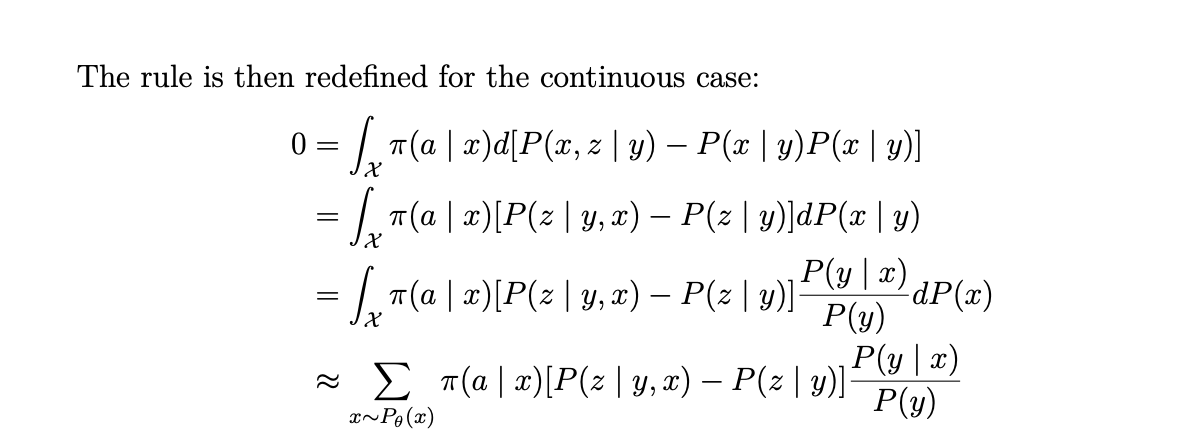

In [24]:
def get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx):
    # compute delta
    term_1 = Pz_yx  - tf.expand_dims(Pz_y, axis=-1) # ok
    term_2 = Py_x / tf.expand_dims(Py,axis=-1) # ok
    delta = term_1 * tf.expand_dims(term_2, axis=0) # ok
    
    # compute c
    exp_Pa_x = tf.expand_dims(tf.expand_dims(Pa_x, axis=0),axis=0)
    exp_delta = tf.expand_dims(delta, axis=-1)
    c = tf.linalg.matmul(exp_Pa_x,
                         exp_delta)
    
    # compute fairness
    fairness = tf.norm(c, ord=1) / Py_x.shape[1]
    return fairness

# def get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx):
#     # compute delta
#     term_1 = Pz_yx  - tf.expand_dims(Pz_y, axis=-1) # ok
#     term_2 = Py_x / tf.expand_dims(Py,axis=-1) # ok
#     delta = term_1 * tf.expand_dims(term_2, axis=0) # ok
    
#     # compute c
#     exp_Pa_x = tf.expand_dims(tf.expand_dims(Pa_x, axis=0),axis=0)
#     exp_delta = tf.expand_dims(delta, axis=-1)
#     c = tf.linalg.matmul(exp_Pa_x,
#                          exp_delta)
    
#     # compute fairness
#     fairness = tf.norm(c, ord=1) / Py_x.shape[1]
#     return fairness

In [25]:
def get_utility_loss(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    neg_utility = - utility
    return tf.math.reduce_mean(neg_utility)

In [26]:
def get_utility_metric(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    return tf.math.reduce_mean(utility)

In [27]:
import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter

utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")
loss_tracker = tf.keras.metrics.Mean(name="loss")

eval_utility_tracker = tf.keras.metrics.Mean(name="eval_utility")
eval_fairness_tracker = tf.keras.metrics.Mean(name="eval_fairness")
eval_loss_tracker = tf.keras.metrics.Mean(name="eval_loss")


class LogisticRegresionTF(tf.keras.Model):
    """
    logistic regresion model , tensorflow
    """
    def __init__(self, input_dim, l):
        super(LogisticRegresionTF, self).__init__()
        self.l = l
        
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, 1), dtype="float32"),
            trainable=True,
        )
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        return tf.nn.sigmoid(tf.matmul(inputs,self.w) + self.b)

In [28]:
def get_models_from_data(data):
    # get Py, Pz_y and models for Py_x & Pz_yx
    Py, Pz_y, model_y_x, model_z_yx = get_models(data)
    
    # get Py_x from data
    Py_x = model_y_x.predict_proba(data[X_atr]).T
    
    # get Pz_yx from data
    Pz_yx = np.zeros((n_z, n_y, data.shape[0]))
    for y in range(n_y):
        tmp_data = data[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx[:,y,:] = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
    return Py, Pz_y, Py_x, Pz_yx

In [29]:
policy_model = LogisticRegresionTF(input_dim=len(X_atr), l = 0.0)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)

In [30]:
train_model = get_models_from_data(train_data)
Py, Pz_y, Py_x, Pz_yx = train_model

In [31]:
epochs = 400

In [32]:
@tf.function
def train_step(policy, data, lamba_parameter, optimizer):
    x, y, Py, Pz_y, Py_x, Pz_yx = data
    # Run forward pass.
    with tf.GradientTape() as tape:
        y_pred = policy(x, training=True)
        utility = get_utility_loss(y_true = y, y_pred = y_pred)
        Pa_x = tf.stack([1 - y_pred, y_pred])
        Pa_x = tf.squeeze(Pa_x, axis=-1, name=None)
        fairness = get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx)
        loss = (1-lamba_parameter) * utility + lamba_parameter * fairness 

    # Run backwards pass.
    optimizer.minimize(loss, policy.trainable_variables, tape=tape)
    # update metrics
    loss_tracker.update_state(loss)
    utility_tracker.update_state(get_utility_metric(y_true = y, y_pred = y_pred))
    fairness_tracker.update_state(fairness)

    metrics = {}
    metrics["fairness_loss"] = fairness_tracker.result()
    metrics["utility"] = utility_tracker.result()
    metrics["loss"] = loss_tracker.result()
    return metrics

In [33]:
@tf.function
def eval_step(policy, data, lamba_parameter):
    x, y, Py, Pz_y, Py_x, Pz_yx = data
    
    y_pred = policy(x, training=False)
    utility = get_utility_metric(y_true = y, y_pred = y_pred)
    Pa_x = tf.stack([1 - y_pred, y_pred])
    Pa_x = tf.squeeze(Pa_x, axis=-1, name=None)
    fairness = get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx)
    loss = (1-lamba_parameter) * utility - lamba_parameter * fairness 

    # update metrics
    eval_loss_tracker.update_state(loss)
    eval_utility_tracker.update_state(get_utility_metric(y_true = y, y_pred = y_pred))
    eval_fairness_tracker.update_state(fairness)

    metrics = {}
    metrics["fairness_loss"] = eval_fairness_tracker.result()
    metrics["utility"] = eval_utility_tracker.result()
    metrics["loss"] = eval_loss_tracker.result()
    return metrics

In [34]:
def reset_trackers(trackers):
    for tracker in trackers:
        tracker.reset_states()

In [35]:
policy_model.get_weights()

[array([[ 3.5295816e-05],
        [-7.6640509e-02],
        [ 4.8645284e-02],
        [ 5.4496806e-02],
        [ 2.2514923e-02],
        [-4.7113236e-02]], dtype=float32),
 0.0]

In [36]:
loss_tracker = tf.keras.metrics.Mean(name="loss")
utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")

# train data
train_model = get_models_from_data(train_data)
Py, Pz_y, Py_x, Pz_yx = train_model

x = tf.convert_to_tensor(train_data[X_atr].values)
y = tf.reshape(tf.convert_to_tensor(train_data[Y_atr].values),(-1,1))

# test data
test_model = get_models_from_data(test_data)
test_tf_Py, test_tf_Pz_y, test_tf_Py_x, test_tf_Pz_yx = (tf.convert_to_tensor(p, dtype="float32") for p in test_model)
test_x = tf.convert_to_tensor(test_data[X_atr].values)
test_y = tf.reshape(tf.convert_to_tensor(test_data[Y_atr].values),(-1,1))
test_data_list = (test_x, test_y, test_tf_Py, test_tf_Pz_y, test_tf_Py_x, test_tf_Pz_yx)


# loop
history = []
eval_history = []
for epoch in range(epochs):
    tf_Py, tf_Pz_y, tf_Py_x, tf_Pz_yx = (tf.convert_to_tensor(p, dtype="float32") for p in train_model)
    
    # training step
    step_results = train_step(policy = policy_model,
                              data = (x, y, tf_Py, tf_Pz_y, tf_Py_x, tf_Pz_yx),
                              lamba_parameter = 0.1,
                              optimizer = optimizer)
    step_results = {key:step_results[key].numpy() for key in step_results.keys()}
    history += [step_results]
    
    # evaluation step
    
    eval_results = eval_step(policy = policy_model,
                             data = test_data_list,
                             lamba_parameter = 0.1)
    
    eval_history +=[eval_results]
    
    
    reset_trackers([loss_tracker, utility_tracker, fairness_tracker,
                    eval_loss_tracker, eval_utility_tracker, eval_fairness_tracker])
    print(f"--- Step : {epoch + 1} \n  ------- {step_results}")

2023-01-30 15:10:49.632338: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


--- Step : 1 
  ------- {'fairness_loss': 0.021751035, 'utility': 0.5060897, 'loss': -0.4533056}
--- Step : 2 
  ------- {'fairness_loss': 0.032652505, 'utility': 0.5092502, 'loss': -0.45505992}
--- Step : 3 
  ------- {'fairness_loss': 0.04260525, 'utility': 0.51216096, 'loss': -0.45668435}
--- Step : 4 
  ------- {'fairness_loss': 0.05142435, 'utility': 0.5147819, 'loss': -0.45816126}
--- Step : 5 
  ------- {'fairness_loss': 0.059300516, 'utility': 0.5171221, 'loss': -0.4594798}
--- Step : 6 
  ------- {'fairness_loss': 0.06613177, 'utility': 0.51919675, 'loss': -0.46066388}
--- Step : 7 
  ------- {'fairness_loss': 0.072141215, 'utility': 0.5210663, 'loss': -0.46174553}
--- Step : 8 
  ------- {'fairness_loss': 0.07745129, 'utility': 0.52275985, 'loss': -0.46273875}
--- Step : 9 
  ------- {'fairness_loss': 0.08217192, 'utility': 0.5243032, 'loss': -0.46365568}
--- Step : 10 
  ------- {'fairness_loss': 0.0863973, 'utility': 0.5257196, 'loss': -0.46450788}
--- Step : 11 
  ------- 

--- Step : 116 
  ------- {'fairness_loss': 0.2035678, 'utility': 0.58293563, 'loss': -0.5042853}
--- Step : 117 
  ------- {'fairness_loss': 0.20416845, 'utility': 0.583276, 'loss': -0.5045315}
--- Step : 118 
  ------- {'fairness_loss': 0.20476417, 'utility': 0.58361393, 'loss': -0.5047761}
--- Step : 119 
  ------- {'fairness_loss': 0.20535564, 'utility': 0.5839497, 'loss': -0.5050191}
--- Step : 120 
  ------- {'fairness_loss': 0.20594236, 'utility': 0.5842829, 'loss': -0.50526035}
--- Step : 121 
  ------- {'fairness_loss': 0.20652494, 'utility': 0.58461386, 'loss': -0.50549996}
--- Step : 122 
  ------- {'fairness_loss': 0.20710282, 'utility': 0.5849424, 'loss': -0.50573784}
--- Step : 123 
  ------- {'fairness_loss': 0.20767651, 'utility': 0.58526886, 'loss': -0.50597435}
--- Step : 124 
  ------- {'fairness_loss': 0.20824596, 'utility': 0.5855931, 'loss': -0.5062092}
--- Step : 125 
  ------- {'fairness_loss': 0.20881084, 'utility': 0.58591485, 'loss': -0.5064423}
--- Step : 12

--- Step : 234 
  ------- {'fairness_loss': 0.25089395, 'utility': 0.61041313, 'loss': -0.5242824}
--- Step : 235 
  ------- {'fairness_loss': 0.25115034, 'utility': 0.6105659, 'loss': -0.5243943}
--- Step : 236 
  ------- {'fairness_loss': 0.25140536, 'utility': 0.61071765, 'loss': -0.5245054}
--- Step : 237 
  ------- {'fairness_loss': 0.25165823, 'utility': 0.6108686, 'loss': -0.5246159}
--- Step : 238 
  ------- {'fairness_loss': 0.25191, 'utility': 0.6110189, 'loss': -0.524726}
--- Step : 239 
  ------- {'fairness_loss': 0.2521597, 'utility': 0.6111679, 'loss': -0.5248351}
--- Step : 240 
  ------- {'fairness_loss': 0.25240824, 'utility': 0.61131614, 'loss': -0.52494365}
--- Step : 241 
  ------- {'fairness_loss': 0.25265473, 'utility': 0.6114635, 'loss': -0.52505165}
--- Step : 242 
  ------- {'fairness_loss': 0.25289974, 'utility': 0.6116101, 'loss': -0.5251591}
--- Step : 243 
  ------- {'fairness_loss': 0.25314352, 'utility': 0.6117556, 'loss': -0.5252657}
--- Step : 244 
  --

--- Step : 360 
  ------- {'fairness_loss': 0.27376655, 'utility': 0.6242798, 'loss': -0.53447515}
--- Step : 361 
  ------- {'fairness_loss': 0.27389374, 'utility': 0.62435836, 'loss': -0.53453314}
--- Step : 362 
  ------- {'fairness_loss': 0.27402017, 'utility': 0.6244366, 'loss': -0.5345909}
--- Step : 363 
  ------- {'fairness_loss': 0.2741462, 'utility': 0.62451446, 'loss': -0.53464836}
--- Step : 364 
  ------- {'fairness_loss': 0.27427134, 'utility': 0.6245919, 'loss': -0.5347055}
--- Step : 365 
  ------- {'fairness_loss': 0.27439624, 'utility': 0.624669, 'loss': -0.5347625}
--- Step : 366 
  ------- {'fairness_loss': 0.27452, 'utility': 0.62474614, 'loss': -0.53481954}
--- Step : 367 
  ------- {'fairness_loss': 0.27464342, 'utility': 0.6248223, 'loss': -0.53487575}
--- Step : 368 
  ------- {'fairness_loss': 0.27476642, 'utility': 0.6248986, 'loss': -0.5349321}
--- Step : 369 
  ------- {'fairness_loss': 0.27488884, 'utility': 0.62497425, 'loss': -0.5349879}
--- Step : 370 


In [37]:
policy_model.get_weights()

[array([[-1.2336928 ],
        [ 0.00591706],
        [ 0.12678933],
        [ 0.17658944],
        [ 0.6579044 ],
        [-0.37780654]], dtype=float32),
 -0.79333895]

In [38]:
history_df = pd.DataFrame(history)
eval_history_df = pd.DataFrame(eval_history)

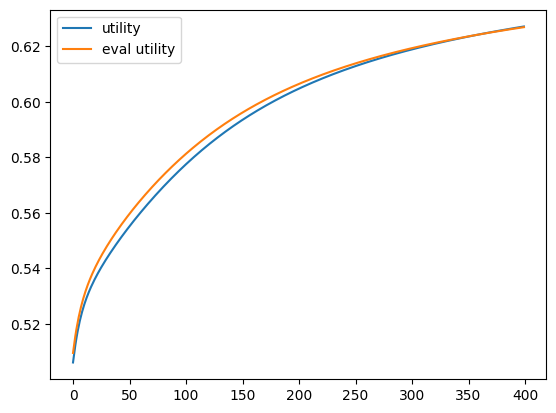

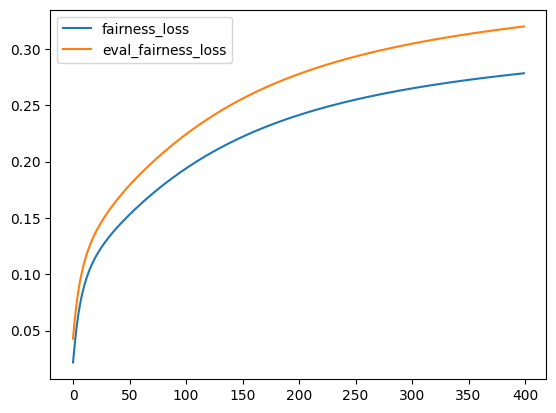

In [39]:
plt.figure()
plt.plot(history_df["utility"],label="utility")
plt.plot(eval_history_df["utility"],label="eval utility")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_df["fairness_loss"],label="fairness_loss")
plt.plot(eval_history_df["fairness_loss"],label="eval_fairness_loss")
plt.legend()
plt.show()

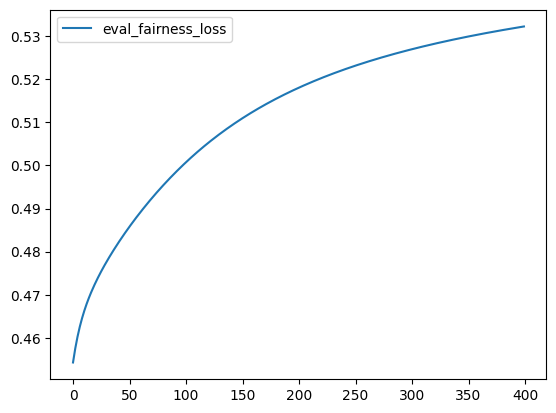

In [40]:
plt.figure()
plt.plot(eval_history_df["loss"],label="eval_fairness_loss")
plt.legend()
plt.show()

# empirical fairness

In [41]:
def empirical_fairness_cont_v11(datas, p_a_x, Pz_y, Py, model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        print(Pz_yx.shape)
        for z in range(Z):
            c = 0
            for i in range(tmp_data.shape[0]):
                delta = (Pz_yx[z, i] - Pz_y[z, y] ) * (Py_x[y, i]/Py[y])
                c += p_a_x[:, i] * delta
            c = c/tmp_data.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF


def empirical_fairness_cont_v12(datas, p_a_x, Pz_y, Py,model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        for z in range(Z):
            c = 0
            j= 0 
            for i in range(tmp_data.shape[0]):
                j = j + 1
                delta = (Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) )
                c += p_a_x[:, i] * delta
            c = c/datas.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

In [42]:
datas= test_data

In [43]:
p_a1 = policy_model.predict(datas[X_atr].astype("float32"))
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T

38/38 [==============================] - 0s 471us/step


In [44]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v11(datas = datas,
                            p_a_x = p_a_x,
                            Pz_y=Pz_y,
                            Py=Py,
                            model_y_x = model_y_x,
                            model_z_yx = model_z_yx )

(12, 1214)
(12, 1214)


0.32023943842796143

In [45]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v12(datas = datas,
                            p_a_x = p_a_x,
                            Pz_y = Pz_y,
                            Py = Py,
                            model_y_x = model_y_x, 
                            model_z_yx = model_z_yx )

1477.363548591733

# Evaluate

In [46]:
def get_delta(Py, Pz_y, Py_x, Pz_yx):
    # compute delta
    term_1 = Pz_yx  - np.expand_dims(Pz_y, axis=-1) # ok
    term_2 = Py_x / np.expand_dims(Py,axis=-1) # ok
    delta = term_1 * np.expand_dims(term_2, axis=0) # ok

    return delta

In [47]:
def get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx):
    # compute delta
    term_1 = Pz_yx  - tf.expand_dims(Pz_y, axis=-1) # ok
    term_2 = Py_x / tf.expand_dims(Py,axis=-1) # ok
    delta = term_1 * tf.expand_dims(term_2, axis=0) # ok
    
    # compute c
    exp_Pa_x = tf.expand_dims(tf.expand_dims(Pa_x, axis=0),axis=0)
    exp_delta = tf.expand_dims(delta, axis=-1)
    c = tf.linalg.matmul(exp_Pa_x,
                         exp_delta)
    
    # compute fairness
    fairness = tf.norm(c, ord=1) / Py_x.shape[1]
    return fairness

In [48]:
def get_fairness(Pa_x, Py, Pz_y, Py_x, Pz_yx):
    # compute delta
    term_1 = Pz_yx  - np.expand_dims(Pz_y, axis=-1) # ok
    term_2 = Py_x / np.expand_dims(Py,axis=-1) # ok
    delta = term_1 * np.expand_dims(term_2, axis=0) # ok
    
    exp_Pa_x = np.expand_dims(np.expand_dims(Pa_x, axis=0),axis=0)
    exp_delta = np.expand_dims(delta, axis=-1)
    c = np.matmul(exp_Pa_x , exp_delta)
    
    # compute fairness
#     fairness = np.linalg.norm(c, ord=1) / Py_x.shape[1]
    return c

In [89]:
def get_fairness(policy, model_delta):
    (Z, Y, X) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            c = np.matmul(policy, model_delta[z, y, :])
            fairness += np.linalg.norm(c, 1) / X
    return fairness

In [103]:
test_models = []
deltas = []
for i in range(16):
    tmp_data = test_data.sample(frac=1.0, replace=True)
    tmp_test_model = get_models_from_data(tmp_data)
    Py, Pz_y, Py_x, Pz_yx = tmp_test_model
    deltas += [get_delta(Py, Pz_y, Py_x, Pz_yx)]

In [104]:
deltas = np.array(deltas)
deltas.shape

(16, 12, 2, 1214)

In [105]:
delta_std = np.std(deltas,axis=0)
mean_std = np.sum(delta_std, axis= (0,1))
sorted_indexies = np.argsort(mean_std)

In [106]:
random_indexies = np.random.choice(a = range(test_data.shape[0]), size = test_data.shape[0], replace=False)

In [152]:
sum(sum(deltas[3,:,:,1]))

-1.0680204550611583e-15

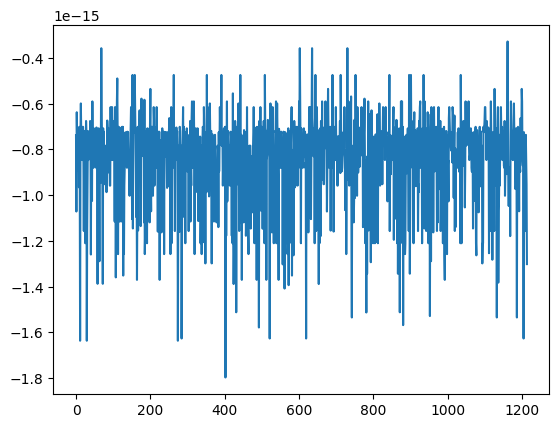

In [159]:
plt.plot(np.sum(deltas[3,:,:,:],axis = (0,1)))

In [132]:
this_indexies = random_indexies

test_model = get_models_from_data(test_data)
test_delta = get_delta(*test_model)

p_a1 = policy_model.predict(test_data[X_atr].astype("float32"))
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T

p_a_x = p_a_x[:, this_indexies]
test_delta = test_delta[:, :, this_indexies] 

fairness_ind = []
for ind in range(test_data.shape[0]):
    tmp_delta = test_delta.copy()
    tmp_delta[:, :, ind:] = 0 
    tmp_fairness = get_fairness(p_a_x,
                                tmp_delta)
#     print(tmp_fairness)
    fairness_ind += [tmp_fairness]
fairness = pd.DataFrame(fairness_ind)

38/38 [==============================] - 0s 267us/step


In [131]:
fairness_sorted = fairness/ 0.31

In [133]:
fairness_random_ordering = fairness

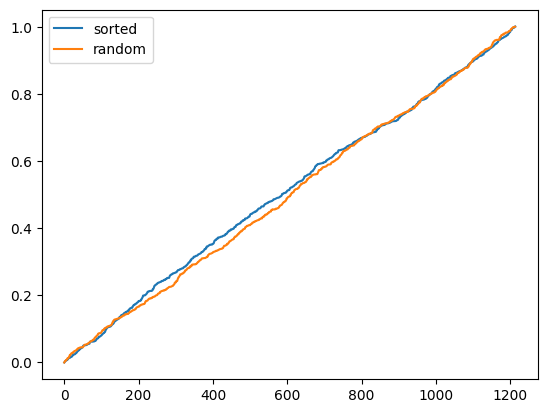

In [137]:
plt.plot(fairness_sorted/ 0.320028, label = "sorted")
plt.plot(fairness_random_ordering/ 0.320028, label = "random")
plt.legend()

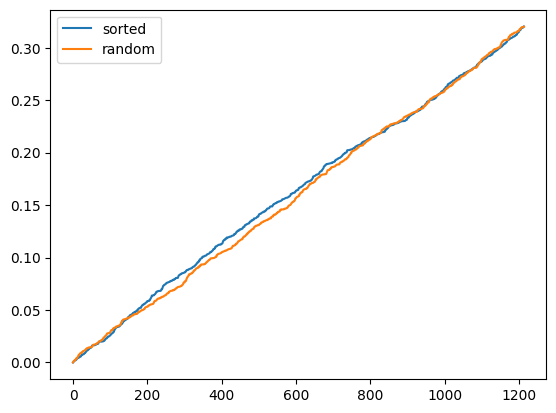

In [138]:
plt.plot(fairness_sorted, label = "sorted")
plt.plot(fairness_random_ordering, label = "random")
plt.legend()

In [136]:
fairness_random_ordering

,0
0,0.000000
1,0.000664
2,0.001379
3,0.001536
4,0.001596
...,...
1209,0.319762
1210,0.319700
1211,0.319779
1212,0.319949
